<a href="https://colab.research.google.com/github/manikur/R-programming/blob/main/Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TIME SERIES

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 34.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=f39689eea1ed203f6e60bddcbf9f5209565f80b931c867219d00e3b87f0ec5c2
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import numpy as np
import os
import random
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import (Dataset, TensorDataset,
 DataLoader, Subset)
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
df = yf.download('GC=F',
 start='2010-01-01',
 end='2021-08-09',
 adjusted=True,
 progress=False)



In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-02,1812.400024,1818.699951,1804.800049,1818.099976,1818.099976,1334
2021-08-03,1812.300049,1813.500000,1806.000000,1810.099976,1810.099976,3341
2021-08-04,1809.300049,1831.300049,1806.300049,1810.500000,1810.500000,2860
2021-08-05,1810.800049,1813.699951,1796.000000,1805.099976,1805.099976,588
2021-08-06,1799.800049,1800.099976,1758.400024,1760.000000,1760.000000,859


In [ ]:
df.rename(columns={'Close': 'price'}, inplace=True)

In [ ]:
df = df.resample('M').last()

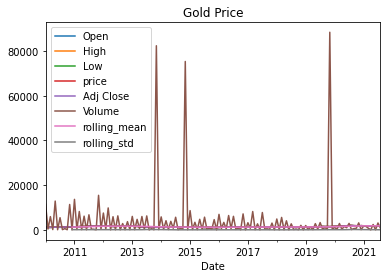

In [ ]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price')

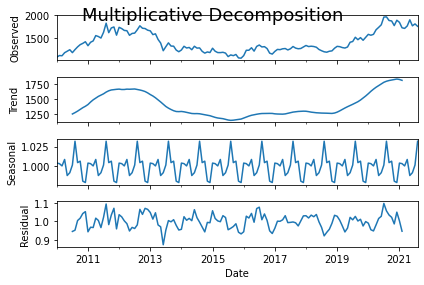

In [ ]:
decomposition_results = seasonal_decompose(df.price,
 model='multiplicative')
decomposition_results.plot() \
 .suptitle('Multiplicative Decomposition',
 fontsize=18);

In [ ]:
import pandas as pd
import seaborn as sns
from fbprophet import Prophet



In [ ]:
df = yf.download('GC=F',
 start='2010-01-01',
 end='2021-08-09',
 adjusted=True,
 progress=False)

In [ ]:
df = df.loc[:, ['Adj Close']]

In [ ]:
df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

In [ ]:
train_indices = df.ds.apply(lambda x: x.year) < 2021
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [ ]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5,fourier_order=5)
model_prophet.fit(df_train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


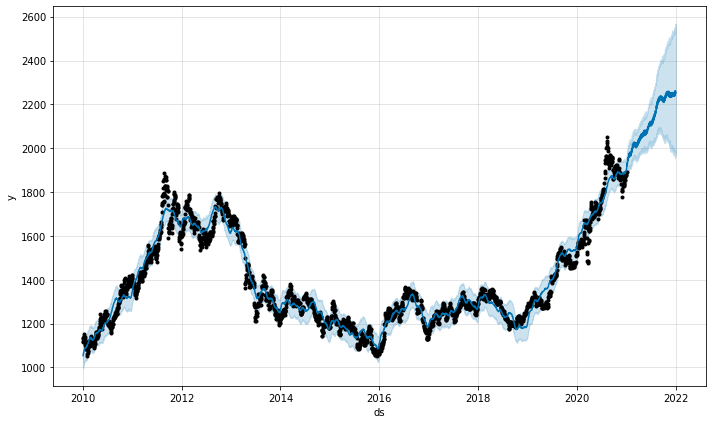

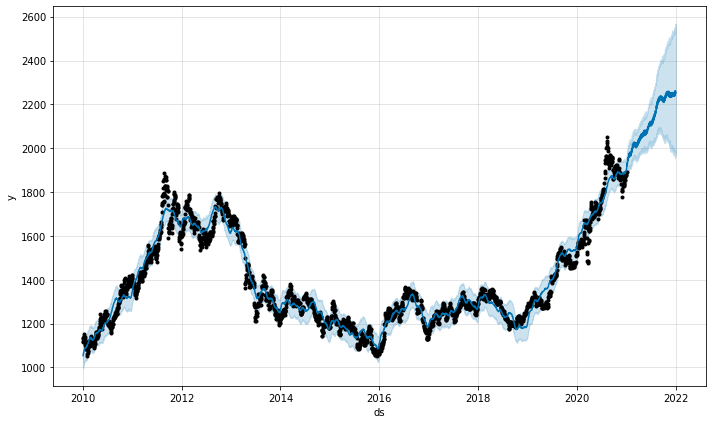

In [ ]:
df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

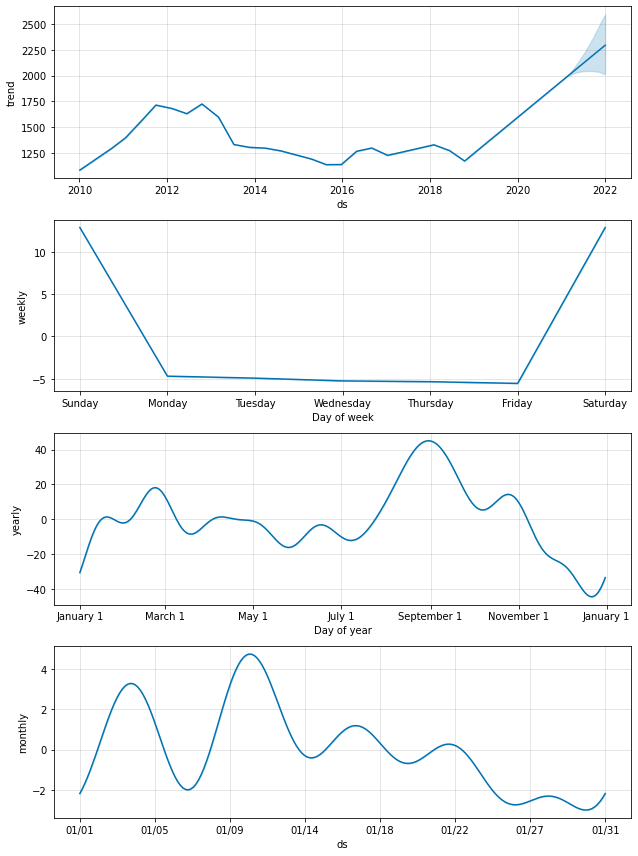

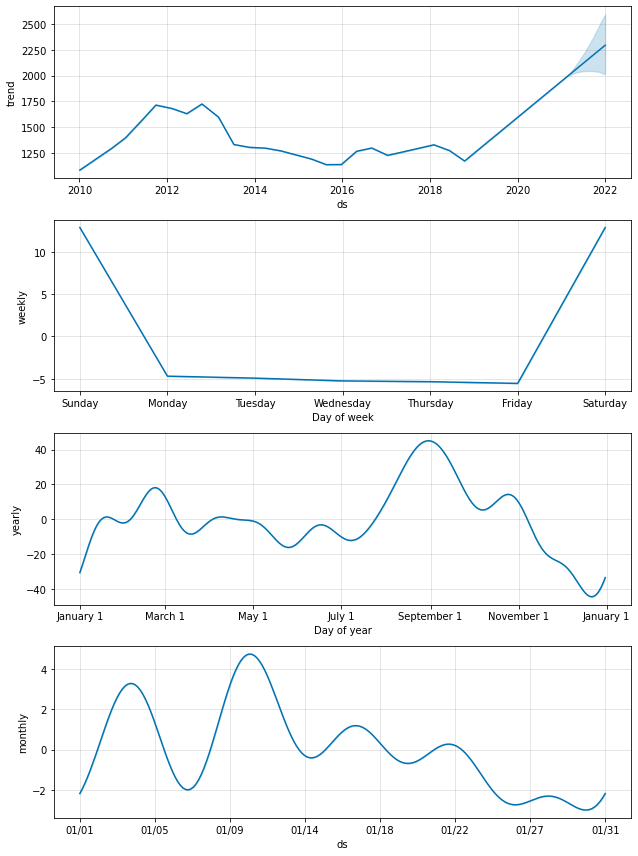

In [ ]:
model_prophet.plot_components(df_pred)

In [ ]:
#Upon closer inspection, we can see that the overall trend is increasing and that the
gold price seems to be higher during the beginning and the end of the year, with a
dip in the summer. On the monthly level, there is some movement, but the scale is
much smaller than in the case of the yearly pattern. There is not a lot of
movement in the weekly chart (we do not look at weekends as there are no prices
for weekends), which makes sense because, with a decrease in the time scale, the
noise starts to wash out the signal. For this reason, we might disable the weekly
level altogether.

In [ ]:
#Execute
the following steps to visually inspect the predicted versus actual gold prices in 2021.

In [ ]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']


In [ ]:
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)


In [ ]:
#Prophet created
predictions for the next 365 days, including weekends and potential holidays

In [ ]:
import matplotlib.pyplot as plt

[Text(0, 0.5, 'Gold Price ($)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Gold Price - actual vs. predicted')]

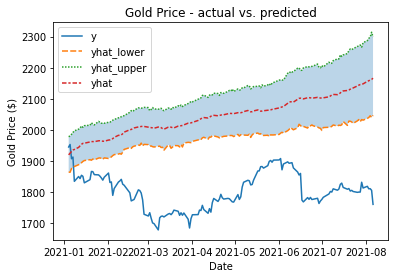

In [ ]:
fig, ax = plt.subplots(1, 1)
ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper','yhat']])
ax.fill_between(df_test.index,
 df_test.yhat_lower,
 df_test.yhat_upper,
 alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted',
 xlabel='Date',
 ylabel='Gold Price ($)')

In [ ]:
#From the preceding plot, we can see that Prophet accurately (at least visually)
predicted the price of gold over 2021. It was all year that
the observed prices were outside of the confidence interval. 

In [ ]:
#We investigate the stationarity of monthly gold prices from the years 2010-2021.

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss


In [ ]:
def adf_test(x):
 indices = ['Test Statistic', 'p-value',
 '# of Lags Used', '# of Observations Used']
 adf_test = adfuller(x, autolag='AIC')
 results = pd.Series(adf_test[0:4], index=indices)
 for key, value in adf_test[4].items():
  results[f'Critical Value ({key})'] = value
 return results

In [ ]:
adf_test(df.y)

Test Statistic              -1.537430
p-value                      0.514921
# of Lags Used               9.000000
# of Observations Used    2885.000000
Critical Value (1%)         -3.432619
Critical Value (5%)         -2.862542
Critical Value (10%)        -2.567304
dtype: float64

In [ ]:
#Define a function for running the KPSS test;

In [ ]:
def kpss_test(x, h0_type='c'):
 indices = ['Test Statistic', 'p-value', '# of Lags']
 kpss_test = kpss(x, regression=h0_type)
 results = pd.Series(kpss_test[0:3], index=indices)
 for key, value in kpss_test[3].items():
  results[f'Critical Value ({key})'] = value
 return results

In [ ]:
kpss_test(df.y)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



Test Statistic            1.576281
p-value                   0.010000
# of Lags                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [ ]:
#With a pvalue of 0.01 (or test statistic greater than the selected critical value), we have
reasons to reject the null hypothesis in favor of the alternative one, meaning that
the series is not stationary

In [ ]:
#Generate the ACF/PACF plots;

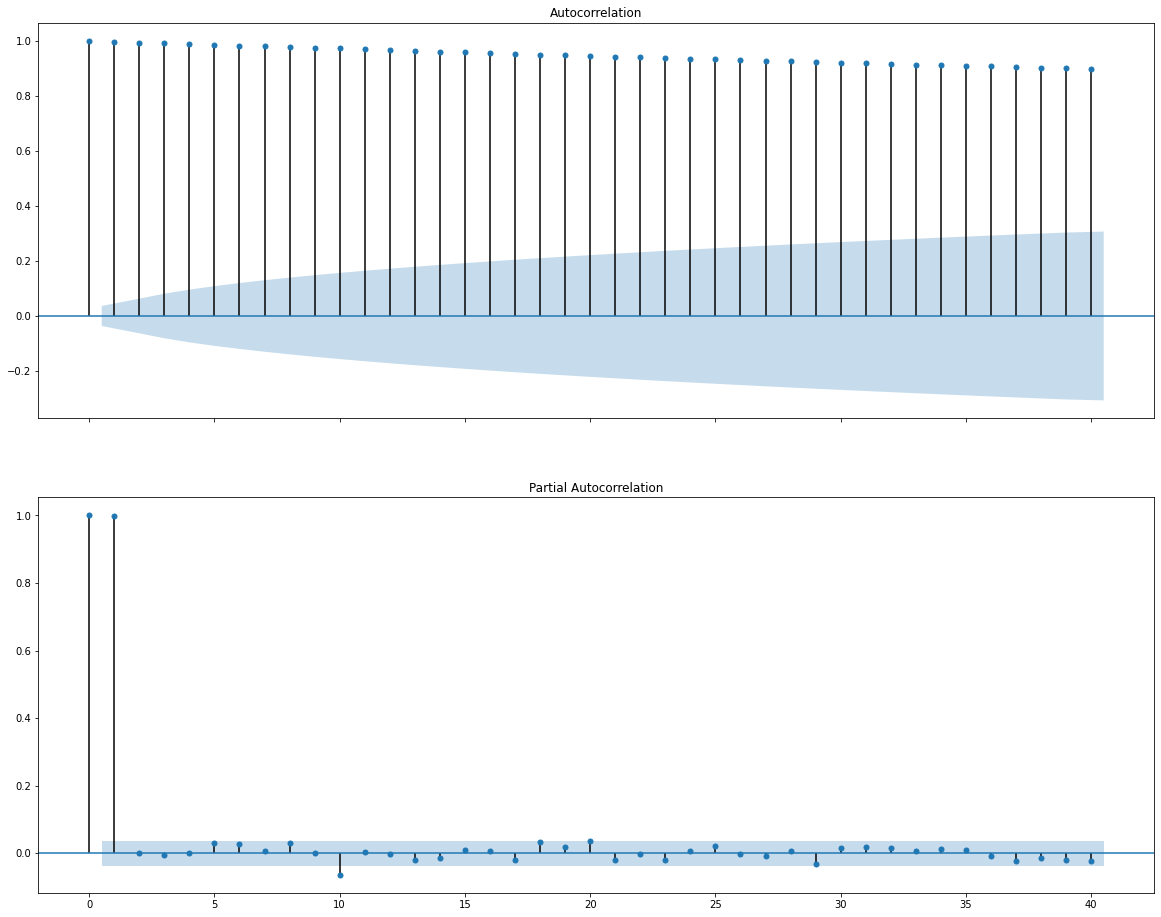

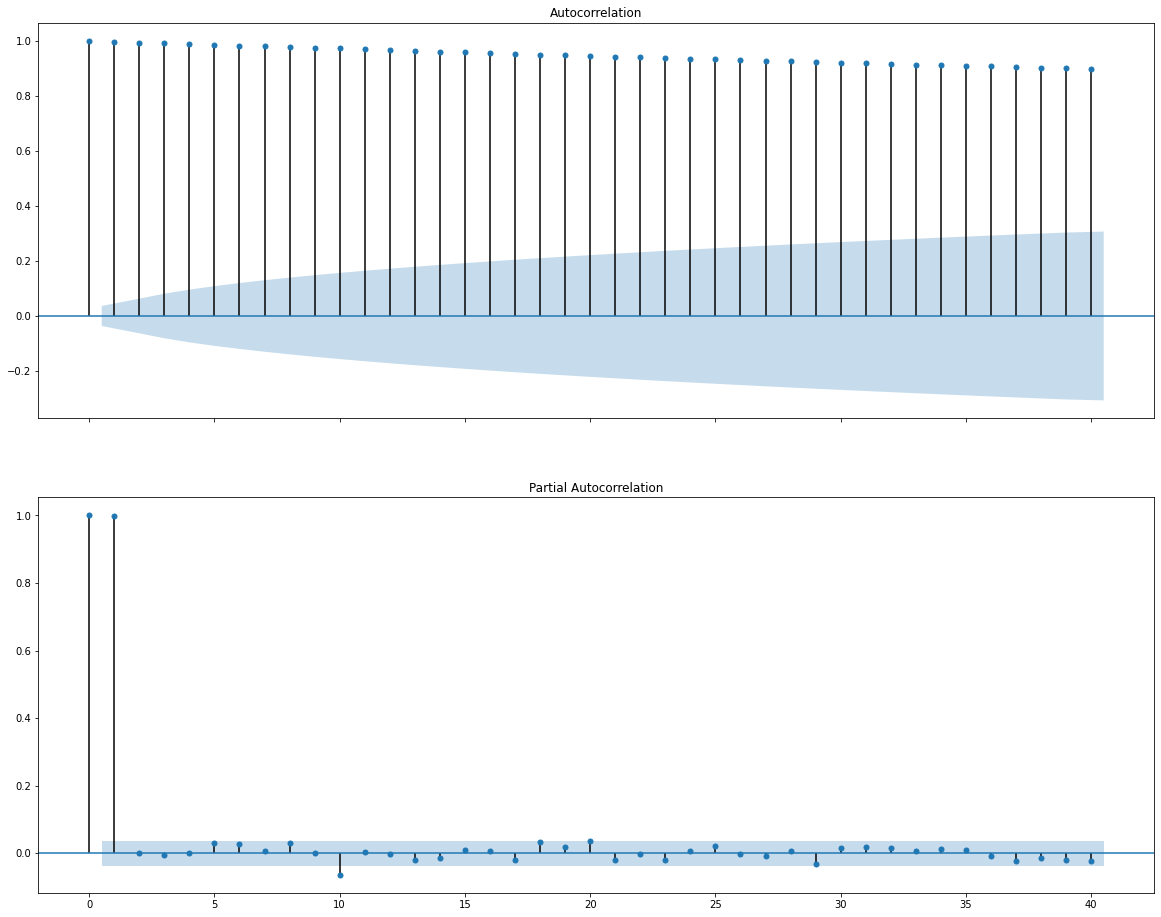

In [ ]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1, figsize=(20, 16), sharex=True)
plot_acf(df.y, ax=ax[0], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.y, ax=ax[1], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)


In [ ]:
#In the ACF plot, we can see that there are significant autocorrelations (above the
95% confidence interval, corresponding to the selected 5% significance level).
There are also some significant autocorrelations at lags 10  PACF plot.

In [ ]:
#transform the series from non-stationary to stationary

In [ ]:
import pandas as pd
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
#Deflate the gold prices (to 2011-12-31 USD values) and plot the results;

In [ ]:
#exponential smoothing methods to create forecasts of
Google's stock prices.


SyntaxError: ignored

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing,
 SimpleExpSmoothing,
 Holt)

In [ ]:
df = yf.download('GOOG',
 start='2010-01-01',
 end='2018-08-09',
 adjusted=True,
 progress=False)


In [ ]:
goog = df.resample('M') \
 .last() \
 .rename(columns={'Adj Close': 'adj_close'}) \
 .adj_close


In [ ]:
train_indices = goog.index.year < 2021
goog_train = goog[train_indices]
goog_test = goog[~train_indices]
test_length = len(goog_test)

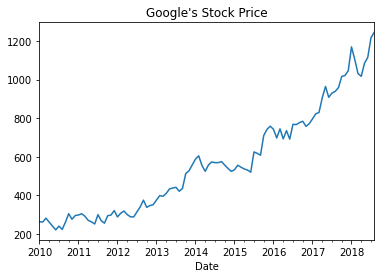

In [ ]:
goog.plot(title="Google's Stock Price")

In [ ]:
#Three ARIMA MODEL

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs



In [ ]:
import pmdarima as pm

ModuleNotFoundError: ignored

In [ ]:
df = yf.download('GOOG',
 start='2015-01-01',
 end='2021-08-09',
 adjusted=True,
 progress=False)


In [ ]:
goog = df.resample('W') \
 .last() \
 .rename(columns={'Adj Close': 'adj_close'}) \
 .adj_close

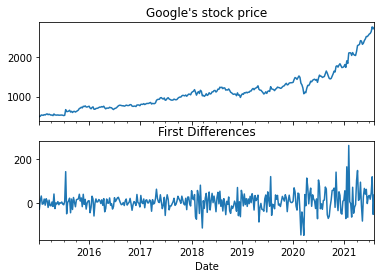

In [ ]:
goog_diff = goog.diff().dropna()
fig, ax = plt.subplots(2, sharex=True)
goog.plot(title = "Google's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')


In [ ]:
#TEST DIFFERENCE SERIES FOR STATIONARITY

In [ ]:
test_autocorrelation(goog_diff)

NameError: ignored

In [ ]:
arima = ARIMA(goog, order=(2, 1, 1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  344
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1770.280
Method:                       css-mle   S.D. of innovations             41.563
Date:                Mon, 09 Aug 2021   AIC                           3550.559
Time:                        16:07:50   BIC                           3569.762
Sample:                    01-11-2015   HQIC                          3558.208
                         - 08-08-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.4406      2.258      2.853      0.005       2.016      10.865
ar.L1.D.adj_close     0.1235      0.561      0.220      0.826      -0.976       1.223
ar.L2.D.adj_close     0.0632      0.060      1.046      0.296      -0.055       0.182
ma.L1.D.adj_close    -0.1805      0.560     -0.322      0.748      -1.279       0.918
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1188           +0.0000j            3.1188            0.0000
AR.2           -5.0720           +0.0000j            5.0720            0.5000
MA.1            5.5416           +0.0000j            5.5416            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
def arima_diagnostics(resids, n_lags=40):
 # create placeholder subplots
 fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
 r = resids
 resids = (r - np.nanmean(r)) / np.nanstd(r)
 resids_nonmissing = resids[~(np.isnan(resids))]
 # residuals over time
 sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
 ax1.set_title('Standardized residuals')
 # distribution of residuals
 x_lim = (-1.96 * 2, 1.96 * 2)
 r_range = np.linspace(x_lim[0], x_lim[1])
 norm_pdf = scs.norm.pdf(r_range)
 sns.distplot(resids_nonmissing, hist=True, kde=True,
 norm_hist=True, ax=ax2)
 ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
 ax2.set_title('Distribution of standardized residuals')
 ax2.set_xlim(x_lim)
 ax2.legend()
 # Q-Q plot
 qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
 ax3.set_title('Q-Q plot')
  # ACF plot
 plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
 ax4.set_title('ACF plot')
 return fig
 arima_diagnostics(arima.resid, 40)